# Load libraries & parameters

In [1]:
%matplotlib inline
import itertools as it
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
import seaborn as sns
import scipy.cluster.hierarchy as spc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BitFlipMutation, SPXCrossover, BinaryTournamentSelection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import PrintObjectivesObserver
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, recall_score
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import datetime
import pickle
from pyod.models.auto_encoder import AutoEncoder
from sklearn.metrics import confusion_matrix
import dill
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
# parameter
n_neighbors = 3
null_percentage = 0.1
test_ratio = 0.2
random_state = 1

epochs = 200
hid_neu = [32, 18, 18, 32]

# Load dataset

In [3]:
#  reading the data
data_ori = pd.read_csv('uci-secom.csv')
data_ori = data_ori.drop(['Time'], axis = 1)
data_ori.loc[data_ori['Fault'] == 1, 'Fault'] = 1
data_ori.loc[data_ori['Fault'] == -1, 'Fault'] = 0

# getting the shape of the data
print(data_ori.shape)

(1567, 591)


In [4]:
output_labels = data_ori['Fault'].value_counts()
fault_fraction = output_labels[1]/float(output_labels[0])
n_all_data = len(data_ori)
n_pass_data = output_labels[0]
n_fail_data = output_labels[1]
print('fault_fraction', fault_fraction)
print('total data', n_all_data)
print('pass data', n_pass_data)
print('fail data', n_fail_data)

fault_fraction 0.0710868079289132
total data 1567
pass data 1463
fail data 104


In [5]:
data_ori.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [6]:
data_ori.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Fault
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,0.066369
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,0.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


# Preprocessing

## Data cleaning

In [7]:
def drop_constant_column(dataframe):
    for column in dataframe.columns:
        unique = dataframe[column].unique()
        unique = unique[~np.isnan(unique)]
        if len(unique) == 1:
            dataframe.drop(column,inplace=True,axis=1)
    return dataframe

# Drop columns with constant value
data_clean = drop_constant_column(data_ori)

# Only keep columns with NaN values below percentage
data_clean = data_clean.loc[:, data_clean.isnull().mean() < null_percentage]

# print precentage of NaN value in each coloumn
print(data_clean.isnull().mean())

data_clean.head()

0        0.003829
1        0.004467
2        0.008934
3        0.008934
4        0.008934
           ...   
586      0.000638
587      0.000638
588      0.000638
589      0.000638
Fault    0.000000
Length: 423, dtype: float64


,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


## Data imputation

In [8]:
# data.replace(np.nan, 0, inplace = True)
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = KNNImputer(n_neighbors=n_neighbors)
imputer.fit(data_clean)
data_impu = pd.DataFrame(imputer.transform(data_clean), columns=data_clean.columns)

print("Is there any null?", data_impu.isnull().any().any())

Is there any null? False


## Data normalization

In [9]:
#returns a numpy array
x = data_impu.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_norm = pd.DataFrame(x_scaled, columns=data_impu.columns, index=data_impu.index)
data_norm.head()

,0,1,2,3,4,6,7,8,9,10,...,577,582,583,584,585,586,587,588,589,Fault
0,0.469231,0.589292,0.499096,0.379841,0.000609,0.328562,0.965785,0.665019,0.542479,0.358362,...,0.112244,0.709375,0.012325,0.017510,0.011880,0.282651,0.144720,0.141304,0.108680,0.0
1,0.575003,0.445535,0.666763,0.393982,0.000133,0.428942,0.969673,0.656639,0.412315,0.228669,...,0.068396,0.753125,0.034637,0.036965,0.033099,0.221387,0.220339,0.181159,0.282386,0.0
2,0.308868,0.583388,0.493903,0.457065,0.000744,0.283455,0.965008,0.542759,0.448168,0.411832,...,0.050771,0.562500,0.020612,0.021401,0.020152,0.629073,0.589309,0.500000,0.112383,1.0
3,0.400385,0.466998,0.543479,0.244894,0.000574,0.469123,0.946345,0.638590,0.319564,0.359499,...,0.043312,0.662500,0.009137,0.007782,0.008734,0.309942,0.152542,0.123188,0.100153,0.0
4,0.471367,0.500400,0.678327,0.357067,0.000765,0.387631,0.960342,0.670606,0.392050,0.315131,...,0.069148,0.068750,1.000000,1.000000,1.000000,0.309942,0.152542,0.123188,0.100153,0.0


In [10]:
data_prepro = data_norm
x_all = data_prepro.iloc[:, :-1]
y_all = data_prepro.iloc[:, -1]

# Correlation & Latency aware Feature Selection

## Get correlation coefficient

In [11]:
# Get correlations of each features in dataset
# Range 0-1
corrmat = abs(data_prepro.corr())
all_correlation = corrmat.values
feat_to_feat_corr = corrmat.iloc[:-1, :-1]
feat_to_label_corr = corrmat.iloc[:-1, -1]

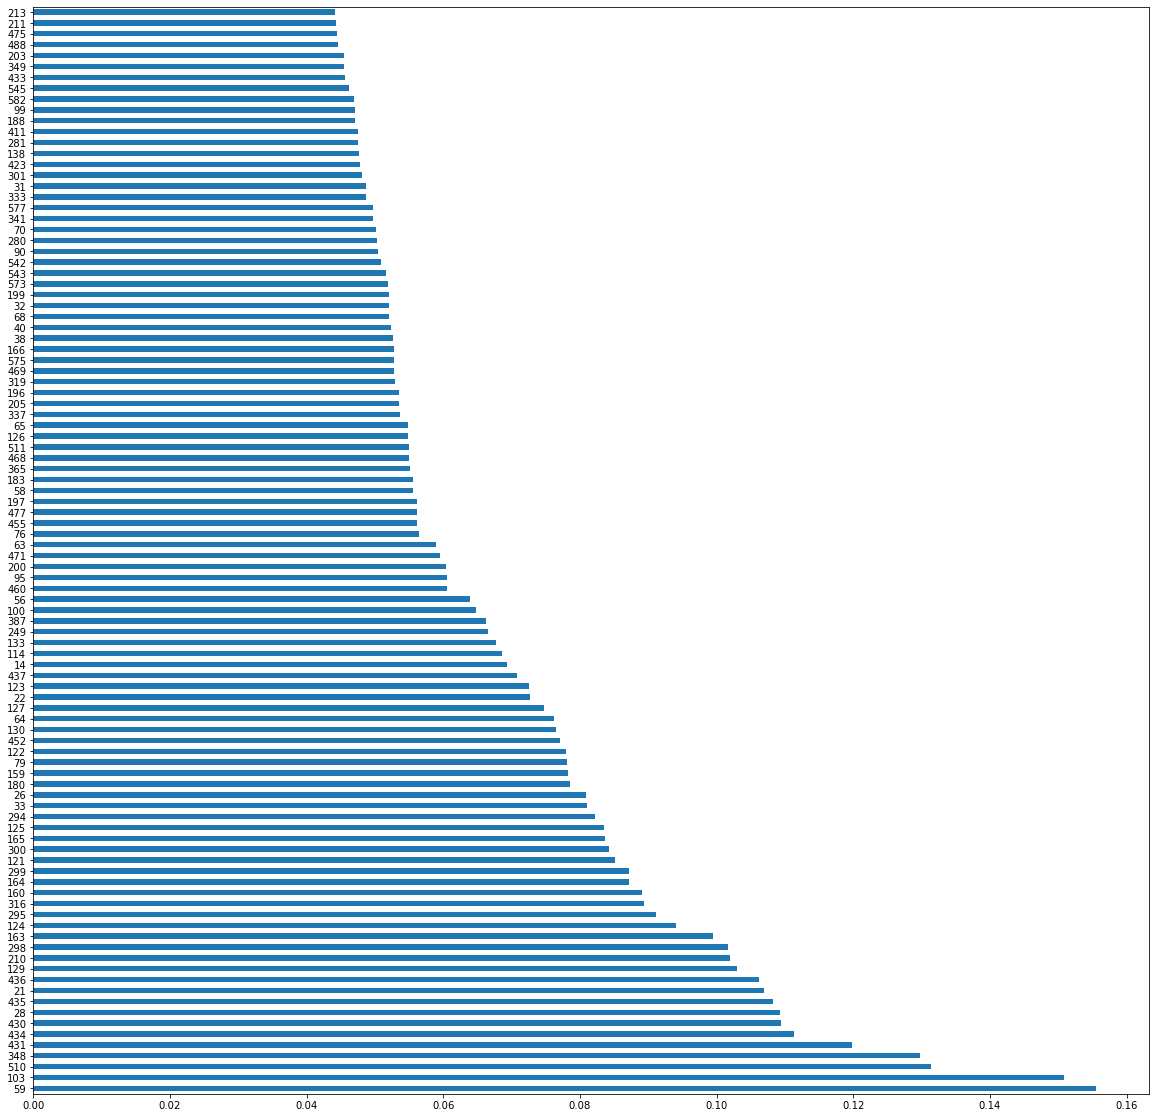

In [12]:
# plot only top 100
feat_to_label_corr.nlargest(100).plot(kind='barh', figsize=(20, 20))
plt.show()

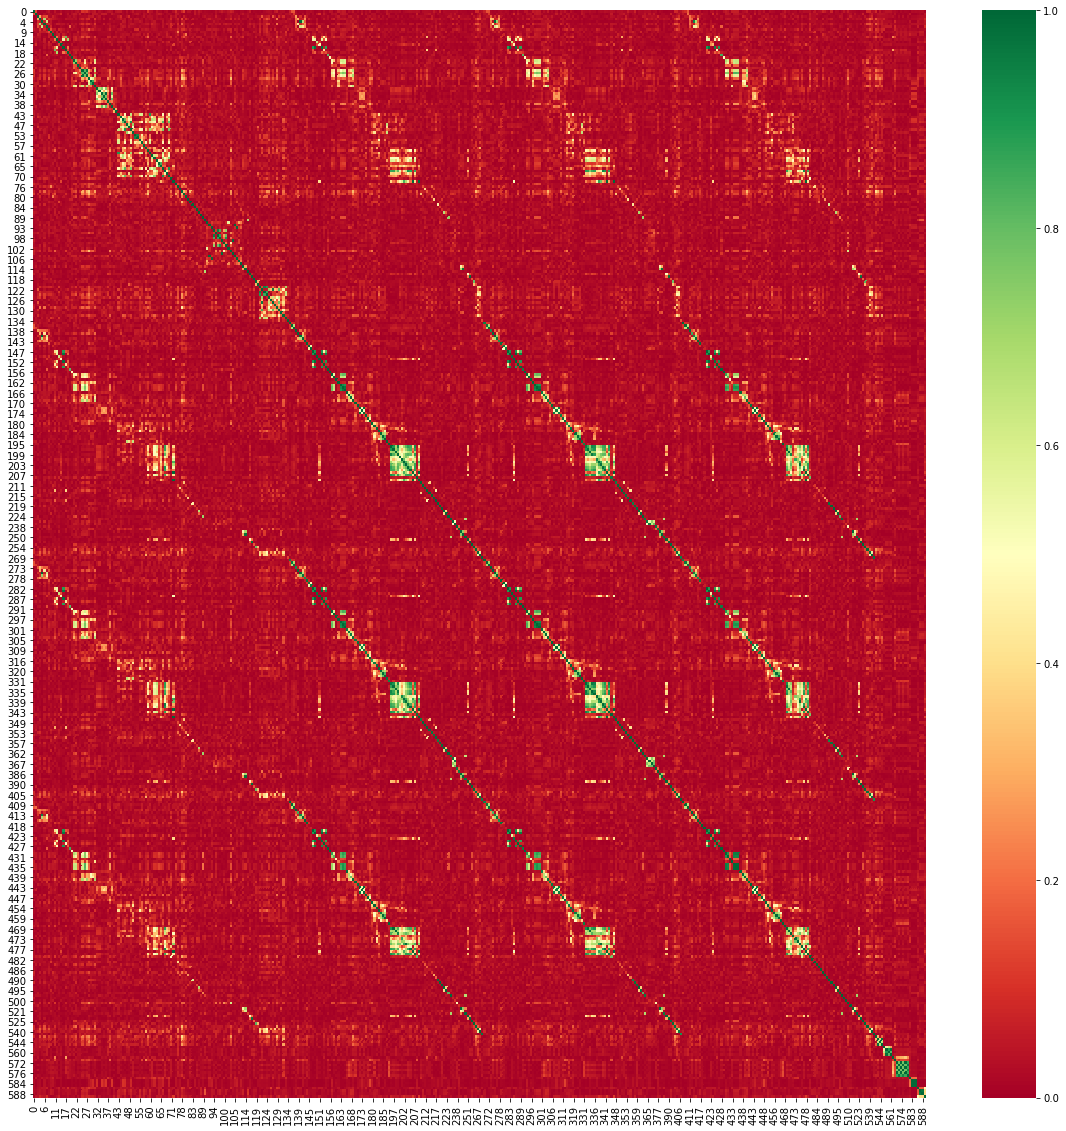

In [13]:
#plot heat map
plt.figure(figsize=(20,20))
# tick labelnya lompat2 biar muat
g=sns.heatmap(feat_to_feat_corr, vmin=0, vmax=1,cmap="RdYlGn")

## Get latency scale

In [14]:
all_latency = np.ones(len(data_prepro.columns))
all_latency = pd.DataFrame(all_latency.reshape(1, -1), columns=data_prepro.columns)

## Genetic algorithm

In [15]:
from jmetal.core.problem import BinaryProblem
from jmetal.core.solution import BinarySolution
import random

# Feature correlation selection
class CLFS(BinaryProblem):

    def __init__(self, correlation, latency, features, weights):
        super(CLFS, self).__init__()

        self.correlation = correlation
        self.latency = latency
        self.features = features
        self.weights = weights
        self.number_of_bits = len(features)
        
        # Minimization to find most independent between variable 
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = 1
        self.number_of_objectives = 1
        self.number_of_constraints = 0

    def evaluate(self, solution: BinarySolution) -> BinarySolution:
        
        # List selected features
        feats = []
        for idx, bits in enumerate(solution.variables[0]):
            if bits:
                feats.append(str(self.features[idx]))
                
        # calculate label correlation
        label_corr = 0
        for j in feats:
            label_corr += (1-self.correlation[j][-1])
        label_corr = label_corr/len(feats)

        # calculate feature correlation
        feat_corr = 0
        comb = list(it.combinations(feats, 2))
        for j in comb:
            feat_corr += self.correlation[j[0]][j[1]]
        feat_corr = feat_corr/len(comb)
        
        # calculate latency scale
        latency_scale = 0
#         for j in feats:
#             latency_scale += self.latency[j]
#         latency_scale = latency_scale/len(feats)
        

        fitness = (weights[0]*label_corr) + (weights[1]*feat_corr) + (weights[2]*latency_scale)
        
        solution.objectives[0] = fitness

        return solution

    def create_solution(self) -> BinarySolution:
        new_solution = BinarySolution(number_of_variables=self.number_of_variables, number_of_objectives=self.number_of_objectives)
        new_solution.variables[0] = [True if random.randint(0, 1) == 1 else False for _ in range(self.number_of_bits)]
        return new_solution
    
    def get_name(self):
        return 'Correlation-Latency aware Feature Selection'

In [16]:
weights = [0.7, 0.3, 0]

problem = CLFS(corrmat, all_latency, x_all.columns, weights)

algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=BitFlipMutation(1.0 / problem.number_of_bits),
        crossover=SPXCrossover(0.8),
        selection=BinaryTournamentSelection(),
        termination_criterion=StoppingByEvaluations(max=300)
    )

algorithm.observable.register(observer=PrintObjectivesObserver())

algorithm.run()
result = algorithm.get_result()

2020-02-11 18:34:22,047 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [0.6936276454380895]
2020-02-11 18:34:41,087 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [0.689585737629991]
2020-02-11 18:35:01,366 [MainThread  ] [INFO ]  Evaluations: 300. fitness: [0.6892396771851221]


In [18]:
variables = x_all.columns[result.variables[0]]

f = open('shared/fcs_ga_info.txt', 'w')
info = '\nAlgorithm: {}'.format(algorithm.get_name())
info += '\nProblem: {}'.format(problem.get_name())
info += '\nSolution: {}'.format(len(variables))
info += '\nFitness: {}'.format(result.objectives[0])
info += '\nComputing time: {}'.format(algorithm.total_computing_time)
print(info)
f.write(info)


Algorithm: Genetic algorithm
Problem: Correlation-Latency aware Feature Selection
Solution: 200
Fitness: 0.6892396771851221
Computing time: 59.49071717262268


158

In [19]:
sel_variables = [str(i) for i in variables]
sel_variables.append('Fault')
sel_data = data_prepro.loc[:, sel_variables]
sel_data.head()

,2,4,6,8,9,10,11,14,17,19,...,558,560,561,572,574,575,577,582,588,Fault
0,0.499096,0.000609,0.328562,0.665019,0.542479,0.358362,0.880692,0.329909,0.958559,0.848739,...,0.229765,0.201402,0.374432,0.011995,0.011971,0.150986,0.112244,0.709375,0.141304,0.0
1,0.666763,0.000133,0.428942,0.656639,0.412315,0.228669,0.932908,0.457039,0.963740,0.830040,...,0.115285,0.046262,0.115808,0.005277,0.005750,0.102807,0.068396,0.753125,0.181159,0.0
2,0.493903,0.000744,0.283455,0.542759,0.448168,0.411832,0.929265,0.420091,0.957079,0.855614,...,0.983876,0.246729,0.186578,0.017006,0.018066,0.077769,0.050771,0.562500,0.500000,1.0
3,0.543479,0.000574,0.469123,0.638590,0.319564,0.359499,0.933515,0.425265,0.960286,0.835631,...,0.434376,0.591822,0.591411,0.012838,0.010993,0.055956,0.043312,0.662500,0.123188,0.0
4,0.678327,0.000765,0.387631,0.670606,0.392050,0.315131,0.915301,0.480818,0.972126,0.834120,...,0.138504,0.066355,0.157791,0.011729,0.012653,0.090288,0.069148,0.068750,0.123188,0.0


In [20]:
sel_corrmat = abs(sel_data.corr())
sel_feat_to_feat_corr = sel_corrmat.iloc[:-1, :-1]
sel_feat_to_label_corr = sel_corrmat.iloc[:-1, -1]

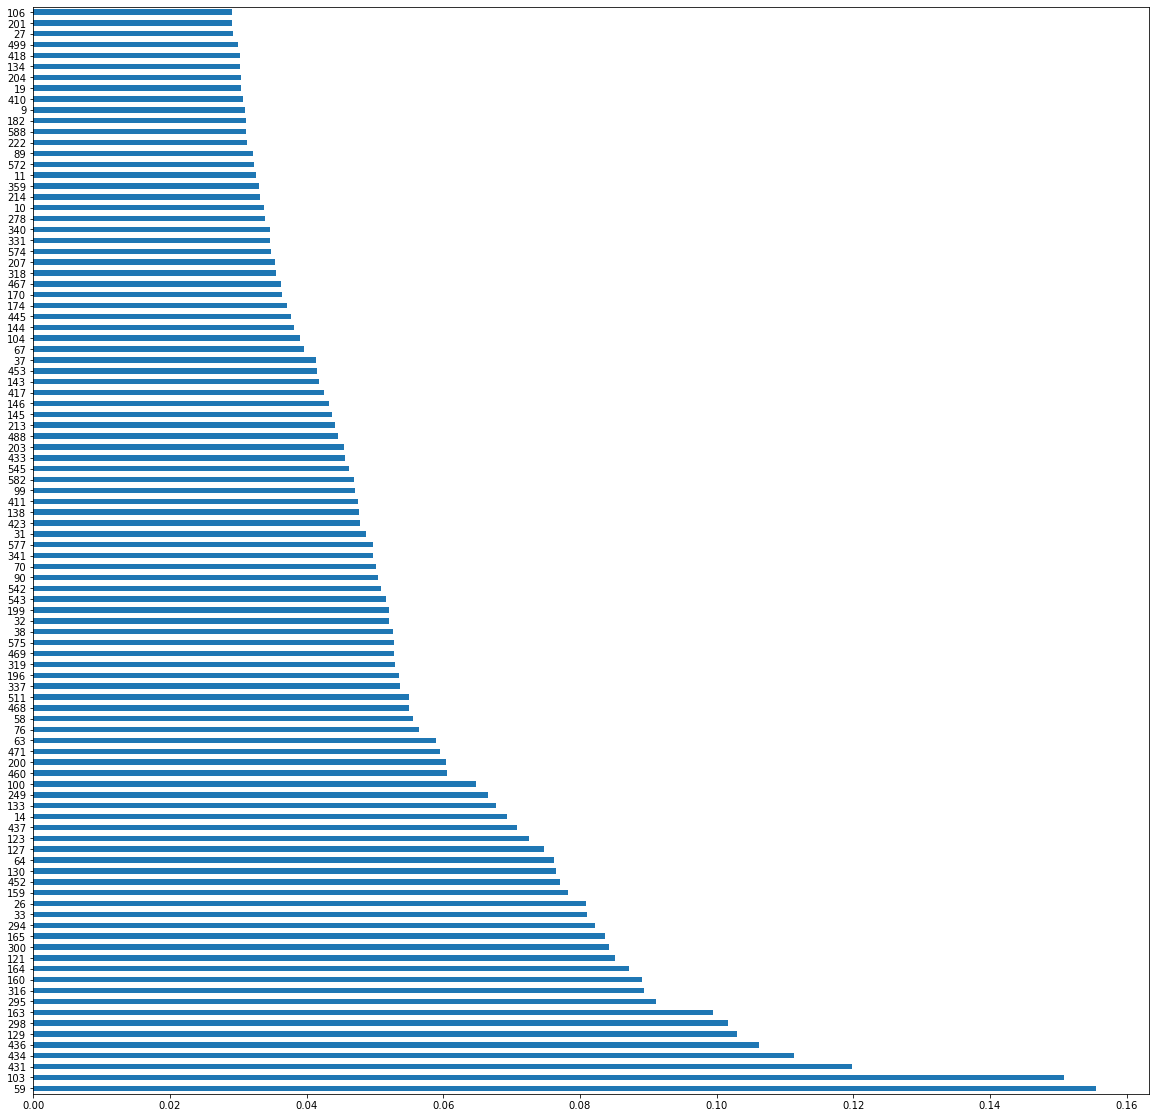

In [21]:
# plot only top 100
sel_feat_to_label_corr.nlargest(100).plot(kind='barh', figsize=(20, 20))
plt.show()

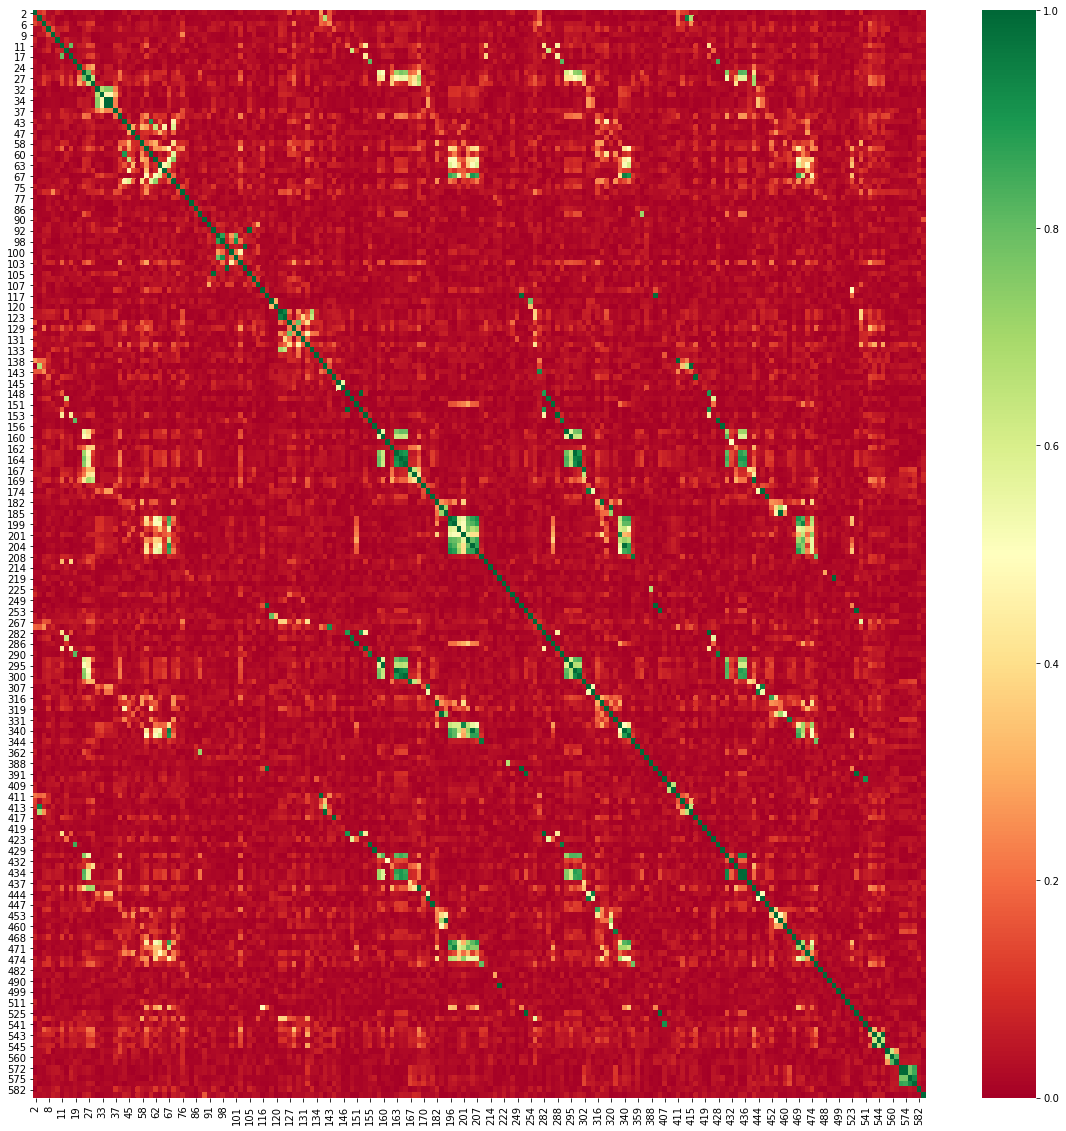

In [22]:
#plot heat map
plt.figure(figsize=(20,20))
# tick labelnya lompat2 biar muat
g=sns.heatmap(sel_feat_to_feat_corr, vmin=0, vmax=1,cmap="RdYlGn")

# Training & Test

## Dataset splitting

In [23]:
n_pass_test_set = int(np.ceil(n_all_data*test_ratio)-n_fail_data)

# split data by class
pass_set = data_prepro[data_prepro['Fault'] == 0]
fail_test_set = data_prepro[data_prepro['Fault'] == 1]

# randomly select and add pass data to become test set
train_set, pass_test_set = train_test_split(pass_set, test_size = n_pass_test_set, random_state = random_state)
test_set = pd.concat([fail_test_set, pass_test_set])

# shuffle test set
test_set = test_set.reindex(np.random.permutation(test_set.index))

x_train = train_set.iloc[:, :-1]
y_train = train_set.iloc[:, -1]

x_test = test_set.iloc[:, :-1]
y_test = test_set.iloc[:, -1]

In [24]:
# Final data
print('Train set', x_train.shape)
print(y_train.value_counts())
print('Test set', x_test.shape)
print(y_test.value_counts())
print("Is there any null in x_train?", x_train.isnull().any().any())
print("Is there any null in y_train?", y_train.isnull().any().any())

Train set (1253, 422)
0.0    1253
Name: Fault, dtype: int64
Test set (314, 422)
0.0    210
1.0    104
Name: Fault, dtype: int64
Is there any null in x_train? False
Is there any null in y_train? False


In [25]:
hid_neu = [64, 32, 18, 32, 64]
from pyod.models.auto_encoder import AutoEncoder

def test_model(clf, x, y, title):
    print('Test on {}'.format(title))
    labels = ['Pass', 'Fail']
    y_pred = clf.predict(x)
    y_scores = clf.decision_function(x)  # outlier scores
    
    # Confusion matrix and classification report
    matrix = confusion_matrix(y, y_pred)
    g=sns.heatmap(matrix,annot=True,cbar=False, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion matrix of {}'.format(title))
    plt.show()
    plt.close()
    
    counts = y.value_counts()
    print(counts)
  
    info = classification_report(y, y_pred, target_names=labels)
    print(info)

def train_model(x, y):
    print('Training')
    clf_name = 'AutoEncoder'
    clf = AutoEncoder(epochs=200, hidden_neurons=hid_neu, contamination=fault_fraction, validation_size=0, random_state=random_state, verbose=2)
    clf.fit(x)

    with open('autoencoder.h5', 'wb') as f:
        dill.dump(clf, f, dill.HIGHEST_PROTOCOL)
    
    return clf

## Model - CLFS features

Training
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)      

Epoch 171/200
 - 0s - loss: 1.6064
Epoch 172/200
 - 0s - loss: 1.5999
Epoch 173/200
 - 0s - loss: 1.5853
Epoch 174/200
 - 0s - loss: 1.5820
Epoch 175/200
 - 0s - loss: 1.5669
Epoch 176/200
 - 0s - loss: 1.5699
Epoch 177/200
 - 0s - loss: 1.5642
Epoch 178/200
 - 0s - loss: 1.5470
Epoch 179/200
 - 0s - loss: 1.5487
Epoch 180/200
 - 0s - loss: 1.5403
Epoch 181/200
 - 0s - loss: 1.5325
Epoch 182/200
 - 0s - loss: 1.5262
Epoch 183/200
 - 0s - loss: 1.5252
Epoch 184/200
 - 0s - loss: 1.5109
Epoch 185/200
 - 0s - loss: 1.5074
Epoch 186/200
 - 0s - loss: 1.5055
Epoch 187/200
 - 0s - loss: 1.5027
Epoch 188/200
 - 0s - loss: 1.4923
Epoch 189/200
 - 0s - loss: 1.4893
Epoch 190/200
 - 0s - loss: 1.4812
Epoch 191/200
 - 0s - loss: 1.4745
Epoch 192/200
 - 0s - loss: 1.4657
Epoch 193/200
 - 0s - loss: 1.4655
Epoch 194/200
 - 0s - loss: 1.4501
Epoch 195/200
 - 0s - loss: 1.4509
Epoch 196/200
 - 0s - loss: 1.4485
Epoch 197/200
 - 0s - loss: 1.4457
Epoch 198/200
 - 0s - loss: 1.4365
Epoch 199/200
 - 0s 

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



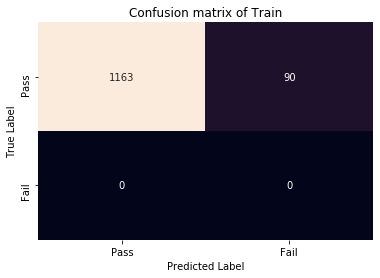

0.0    1253
Name: Fault, dtype: int64
              precision    recall  f1-score   support

        Pass       1.00      0.93      0.96      1253
        Fail       0.00      0.00      0.00         0

    accuracy                           0.93      1253
   macro avg       0.50      0.46      0.48      1253
weighted avg       1.00      0.93      0.96      1253



C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [26]:
x_train_sel = x_train.loc[:, variables]
clf_clfs = train_model(x_train_sel, y_train)
test_model(clf_clfs, x_train_sel, y_train, 'Train')

Test on Test


C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



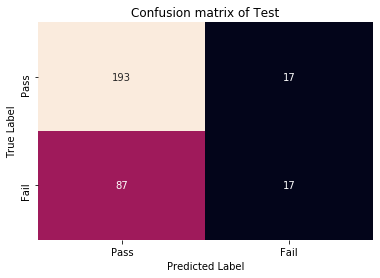

0.0    210
1.0    104
Name: Fault, dtype: int64
              precision    recall  f1-score   support

        Pass       0.69      0.92      0.79       210
        Fail       0.50      0.16      0.25       104

    accuracy                           0.67       314
   macro avg       0.59      0.54      0.52       314
weighted avg       0.63      0.67      0.61       314



In [27]:
x_test_sel = x_test.loc[:, variables]
test_model(clf_clfs, x_test_sel, y_test, 'Test')

## Model - all features

In [28]:
clf_all = train_model(x_train, y_train)
test_model(clf_all, x_train_sel, y_train, 'Train')

Training
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 422)               178506    
_________________________________________________________________
dropout_8 (Dropout)          (None, 422)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 422)               178506    
_________________________________________________________________
dropout_9 (Dropout)          (None, 422)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                27072     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)      

 - 0s - loss: 2.2001
Epoch 171/200
 - 0s - loss: 1.9102
Epoch 172/200
 - 0s - loss: 1.8892
Epoch 173/200
 - 0s - loss: 1.8936
Epoch 174/200
 - 0s - loss: 1.8829
Epoch 175/200
 - 0s - loss: 1.8748
Epoch 176/200
 - 0s - loss: 1.8589
Epoch 177/200
 - 0s - loss: 1.8488
Epoch 178/200
 - 0s - loss: 1.8359
Epoch 179/200
 - 0s - loss: 1.8329
Epoch 180/200
 - 0s - loss: 1.8278
Epoch 181/200
 - 0s - loss: 1.8162
Epoch 182/200
 - 0s - loss: 1.8014
Epoch 183/200
 - 0s - loss: 1.7971
Epoch 184/200
 - 0s - loss: 1.7853
Epoch 185/200
 - 0s - loss: 1.7703
Epoch 186/200
 - 0s - loss: 1.7774
Epoch 187/200
 - 0s - loss: 1.7529
Epoch 188/200
 - 0s - loss: 1.7574
Epoch 189/200
 - 0s - loss: 1.7557
Epoch 190/200
 - 0s - loss: 1.7332
Epoch 191/200
 - 0s - loss: 1.7224
Epoch 192/200
 - 0s - loss: 1.7366
Epoch 193/200
 - 0s - loss: 1.7132
Epoch 194/200
 - 0s - loss: 1.7002
Epoch 195/200
 - 0s - loss: 1.6960
Epoch 196/200
 - 0s - loss: 1.6839
Epoch 197/200
 - 0s - loss: 1.6935
Epoch 198/200
 - 0s - loss: 1.6750

C:\Users\HANSUNG\.conda\envs\HAR\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



ValueError: operands could not be broadcast together with shapes (1253,200) (422,) (1253,200) 

In [ ]:
test_model(clf_all, x_test, y_test, 'Test')

# Server-client code

In [ ]:
# # Server
# import socket
# import json
# import numpy as np

# port = 4000
# s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
# s.bind(('', port))

# print("Server Started")
# while True:
#     data, addr = s.recvfrom(1024)
#     data = json.loads(data.decode())
#     print("Message from: " + str(addr))
#     print("From connected user: ", msg = data.get("msg"))
#     message = json.dumps({"msg": 'success'})
#     s.sendto(message.encode(), addr)

In [ ]:
for (columnName, columnData) in x_all.iteritems():
    x = columnData.values.tolist()

In [ ]:
# # Client
# import datetime
# import socket
# import json

# server = ('192.168.10.3', 4000)
# s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
# s.connect(server)

# print(x_all.shape)    
# start = datetime.datetime.now()
# for (columnName, columnData) in x_all.iteritems():
# #     print('Colunm Name : ', columnName)
# #     print('Column Contents : ', columnData.values)
#     x = columnData.values.tolist()
#     message = json.dumps({"msg": x})
#     s.sendto(message.encode(), server)
#     data, addr = s.recvfrom(1024)
#     data = json.loads(data.decode())
#     print("Received from server: ", data.get("msg"))
#     break
# s.close()
# end = datetime.datetime.now()
# interval = end - start
# print(interval)